# Notebook 3 - IGTI - Módulo 1 - Character Predictions
- Autor: Caio Gabriel de Moraes
- Data : 27/05/2020
- LinkedIn: https://www.linkedin.com/in/caio-moraes-8026a6158/

## Carregando as Bibliotecas

In [1]:
# import de avisos
import sys
import warnings
import matplotlib.cbook
warnings.simplefilter("ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# import para a manipulação dos dados
import pandas as pd
import numpy as np
import scipy
import math

# import para a visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

# import para os modelos de seleção
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict

# import para os modelos de regressão logistica
from sklearn.linear_model import LogisticRegression

# import para os modelos de classificação
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# import para as métricas das classificação
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# especificando quais nós devem ser executados interativamente
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# declarando o tamanho maximo das linhas e colunas
pd.options.display.max_columns = 2000
pd.options.display.max_rows = 2000

# mostrar todas as colunas da tabela
pd.set_option('display.max_columns', None)

In [2]:
# versões dos pacotes usados nesse jupyter notebook
%reload_ext watermark
%watermark -a "Notebook 3 - Módulo 1 - Caio Moraes" --iversions

scipy      1.4.1
numpy      1.18.1
pandas     1.0.3
seaborn    0.10.1
matplotlib 3.2.0
Notebook 3 - Módulo 1 - Caio Moraes


## Criando as Funções

In [3]:
# função para verificar os valores únicos
def unique_values(df):
    print("-" * 40)
    for c in df.columns:
        print("Coluna: {0}".format(c))
        print()
        if df[c].nunique() < 15:
            print("Valores Únicos: {0}".format(df[c].unique()))
            print()
        print("Quantidade: {0}".format(df[c].nunique()))
        print()
        print("Tipo: {0}".format(df[c].dtype))
        print()
        if df[c].dtype == np.int64 or df[c].dtype == np.float64 or df[c].dtype == np.dtype("M8[ns]"):
            print("Menor Valor: {0}".format(min(df[c])))
            print("Maior Valor: {0}".format(max(df[c])))
        print("-" * 40)
        
        
# função para criar um gráfico de distribuição para cada feature no dataset
def plot_distribution(dataset, cols=5, width=20, height=25, hspace=0.4, wspace=0.5):
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1] / cols))
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset, order=dataset[column].value_counts().index[:10])
            substrings = [s.get_text()[:20] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)

## Trabalhando com o Dataset

In [4]:
# carregando o dataset
df_char_pred = pd.read_csv("character-predictions.csv")

In [5]:
# mostrando o dataset
df_char_pred.head()

,S.No,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,DateoFdeath,mother,father,heir,house,spouse,book1,book2,book3,book4,book5,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,1,0,0,0.054,0.946,Viserys II Targaryen,NaN,1,NaN,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,NaN,0,0,0,0,0,1.0,0.0,0.0,NaN,0,0,NaN,11,1,1,0.605351,0
1,2,1,0,0.387,0.613,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,NaN,NaN,NaN,NaN,House Frey,Perra Royce,1,1,1,1,1,NaN,NaN,NaN,1.0,1,1,97.0,1,1,1,0.896321,1
2,3,1,0,0.493,0.507,Addison Hill,Ser,1,NaN,NaN,NaN,NaN,NaN,NaN,House Swyft,NaN,0,0,0,1,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0,0,0.267559,1
3,4,0,0,0.076,0.924,Aemma Arryn,Queen,0,NaN,82.0,105.0,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,0,0,0,0,0,NaN,NaN,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
4,5,1,1,0.617,0.383,Sylva Santagar,Greenstone,0,Dornish,276.0,NaN,NaN,NaN,NaN,House Santagar,Eldon Estermont,0,0,0,1,0,NaN,NaN,NaN,1.0,1,1,29.0,0,0,0,0.043478,1


In [6]:
# mostrando a dimensão do dataset
df_char_pred.shape

(1946, 33)

In [7]:
# mostrando as informações do dataset
df_char_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No               1946 non-null   int64  
 1   actual             1946 non-null   int64  
 2   pred               1946 non-null   int64  
 3   alive              1946 non-null   float64
 4   plod               1946 non-null   float64
 5   name               1946 non-null   object 
 6   title              938 non-null    object 
 7   male               1946 non-null   int64  
 8   culture            677 non-null    object 
 9   dateOfBirth        433 non-null    float64
 10  DateoFdeath        444 non-null    float64
 11  mother             21 non-null     object 
 12  father             26 non-null     object 
 13  heir               23 non-null     object 
 14  house              1519 non-null   object 
 15  spouse             276 non-null    object 
 16  book1              1946 

In [8]:
# transformando as data de object para datetime
df_char_pred["dateOfBirth"] = pd.to_datetime(df_char_pred["dateOfBirth"])
df_char_pred["DateoFdeath"] = pd.to_datetime(df_char_pred["DateoFdeath"])

In [9]:
# mostrando as informações do dataset
df_char_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   S.No               1946 non-null   int64         
 1   actual             1946 non-null   int64         
 2   pred               1946 non-null   int64         
 3   alive              1946 non-null   float64       
 4   plod               1946 non-null   float64       
 5   name               1946 non-null   object        
 6   title              938 non-null    object        
 7   male               1946 non-null   int64         
 8   culture            677 non-null    object        
 9   dateOfBirth        433 non-null    datetime64[ns]
 10  DateoFdeath        444 non-null    datetime64[ns]
 11  mother             21 non-null     object        
 12  father             26 non-null     object        
 13  heir               23 non-null     object        
 14  house   

In [10]:
# mostrando os valores únicos
unique_values(df_char_pred)

----------------------------------------
Coluna: S.No

Quantidade: 1946

Tipo: int64

Menor Valor: 1
Maior Valor: 1946
----------------------------------------
Coluna: actual

Valores Únicos: [0 1]

Quantidade: 2

Tipo: int64

Menor Valor: 0
Maior Valor: 1
----------------------------------------
Coluna: pred

Valores Únicos: [0 1]

Quantidade: 2

Tipo: int64

Menor Valor: 0
Maior Valor: 1
----------------------------------------
Coluna: alive

Quantidade: 693

Tipo: float64

Menor Valor: 0.0
Maior Valor: 1.0
----------------------------------------
Coluna: plod

Quantidade: 693

Tipo: float64

Menor Valor: 0.0
Maior Valor: 1.0
----------------------------------------
Coluna: name

Quantidade: 1946

Tipo: object

----------------------------------------
Coluna: title

Quantidade: 262

Tipo: object

----------------------------------------
Coluna: male

Valores Únicos: [1 0]

Quantidade: 2

Tipo: int64

Menor Valor: 0
Maior Valor: 1
----------------------------------------
Coluna: cultu

### Observações
- São 1946 registros e 33 features:
	- S.No == N° Série: Do tipo int64 (índice do 1 até 1946).
	- Actual == Real: do tipo int64 com dois valores distintos (0 1).
	- Pred == Pred: do tipo int64 com dois valores distintos (0 1).
	- Alive == Vivo: do tipo float64 com 693 valores distintos (do 0.0 até 1.0).
	- Plod == Plod: do tipo float64 com 693 valores distintos (do 0.0 até 1.0).
	- Name == Nome: do tipo object com 1946 nomes distintos.
	- Title == Título: do tipo object com 262 títulos distintos.
	- Male == Masculino: do tipo int64 com dois valores distintos (0 1).
	- Culture == Cultura: do tipo object com 64 valores distintos.
	- DateOfBirth == Data de Nascimento: do tipo datetime64[ns] com 134 datas distintas.
	- DateOfDeath == Dia da Morte: do tipo datetime64[ns] com 69 datas distintas.
	- Mother == Mãe: do tipo object com 17 mães distintos.
	- Father == Pai: do tipo object com 22 pais distintos.
	- Heir == Herdeiro: do tipo object com 22 herdeiros distintos.
	- House == Casa: do tipo object com 347 casas distintas.
	- Spouse == Cônjuge: do tipo object com 254 cônjuge distintas.
	- Book1 == Livro1: do tipo int64 com 2 valores distintos (0 1).
	- Book2 == Livro2: do tipo int64 com 2 valores distintos (0 1).
	- Book3 == Livro3: do tipo int64 com 2 valores distintos (0 1).
	- Book4 == Livro4: do tipo int64 com 2 valores distintos (0 1).
	- Book5 == Livro5: do tipo int64 com 2 valores distintos (0 1).
	- IsAliveMother == É Mãe Viva: do tipo float64 com 2 valores distintos (0.0 1.0).
	- IsAliveFather == É Pai Vivo: do tipo float64 com 2 valores distintos (0.0 1.0).
	- IsAliveHeir == É Herdeiro Vivo: do tipo float64 com 2 valores distintos (0.0 1.0).
	- IsAliveSpouse == É Cônjuge Viva: do tipo float64 com 2 valores distintos (0.0 1.0).
	- IsMarried == É Casado: do tipo int64 com 2 valores distintos (0 1).
	- IsNoble == É Nobre: do tipo int64 com 2 valores distintos (0 1).
	- Age == Idade: do tipo float com 85 idades distintas.
	-  NumDeadRelations == Número de Relações Mortas: do tipo int64 com 2 valores distintos (0 1).
	- BoolDeadRelations == Bool Relações Mortas: do tipo int64 com 2 valores distintos (0 1).
	- IsPopular == É Popular: do tipo int64 com 2 valores distintos (0 1).
	- Popularity == Popularidade: do tipo float64 com 166 valores distintos (do 0.0 até 1.0).
	- IsAlive == É Vivo: do tipo int64 com 2 valores distintos (0 1).
- As duas features do tipo datatime (date_of_departure e date_of_arrival) eram do tipo object e transformamos no tipo datetime para podermos mostrar a maior e a menor data contida no dataset

## Análise Exploratória dos Dados

In [11]:
# mostrando a descrição do dataset
df_char_pred.describe()

,S.No,actual,pred,alive,plod,male,book1,book2,book3,book4,book5,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
count,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,21.000000,26.000000,23.000000,276.000000,1946.000000,1946.000000,433.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000
mean,973.500000,0.745632,0.687050,0.634470,0.365530,0.619219,0.198356,0.374615,0.480473,0.591984,0.395170,0.714286,0.192308,0.652174,0.778986,0.141829,0.460946,-1293.563510,0.305755,0.074512,0.059096,0.089584,0.745632
std,561.906131,0.435617,0.463813,0.312637,0.312637,0.485704,0.398864,0.484148,0.499747,0.491593,0.489013,0.462910,0.401918,0.486985,0.415684,0.348965,0.498601,19564.340993,1.383910,0.262669,0.235864,0.160568,0.435617
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-298001.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,487.250000,0.000000,0.000000,0.391250,0.101000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.013378,0.000000
50%,973.500000,1.000000,1.000000,0.735500,0.264500,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.033445,1.000000
75%,1459.750000,1.000000,1.000000,0.899000,0.608750,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,50.000000,0.000000,0.000000,0.000000,0.086957,1.000000
max,1946.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,15.000000,1.000000,1.000000,1.000000,1.000000


- count = número de elementos (linhas) existente no banco de dados
- mean = média dos valores na coluna
- std = desvio padrão dos dados presentes na coluna
- min = menor valor existente na coluna
- 25% = primeiro quartil dos dados (25%)
- 50% = segundo quartil dos dados (50%)
- 75% = terceiro quartil dos dados (75%)
- max = valor máximo existente na coluna

In [12]:
# verificando a média da idade
df_char_pred["age"].mean()

-1293.5635103926097

In [13]:
# verificando os valores negativos da coluna age
indices = df_char_pred["age"][df_char_pred["age"] < 0].index

# mostrando os valores negativos da coluna age
print("{0} - {1}: {2}".format((indices[0]), (df_char_pred["name"][df_char_pred["age"] < 0].values[0]), (df_char_pred["age"][df_char_pred["age"] < 0].values[0])))
print("{0} - {1}: {2}".format((indices[1]), (df_char_pred["name"][df_char_pred["age"] < 0].values[1]), (df_char_pred["age"][df_char_pred["age"] < 0].values[1])))

1684 - Doreah: -277980.0
1868 - Rhaego: -298001.0


In [14]:
# substituindo os valores negativos
df_char_pred.loc[1684, "age"] = 25.0
df_char_pred.loc[1868, "age"] = 0.0

In [15]:
# verificando novamente a media da coluna age
df_char_pred["age"].mean()

36.70438799076212

In [16]:
# verificando se existe valores nulos
nans = df_char_pred.isnull().sum()

# mostrar apenas as colunas que existe valores nulos
nans[nans > 0]

title            1008
culture          1269
dateOfBirth      1513
DateoFdeath      1502
mother           1925
father           1920
heir             1923
house             427
spouse           1670
isAliveMother    1925
isAliveFather    1920
isAliveHeir      1923
isAliveSpouse    1670
age              1513
dtype: int64

In [17]:
# substituindo os valores nulos das colunas age e culture
df_char_pred["age"].fillna(df_char_pred["age"].mean(), inplace=True)  # substituindo os valores nulos pela média da coluna
df_char_pred["culture"].fillna("", inplace=True)  # substituindo os valores nulos da coluna cultura com uma string nula

# substituindo os demais valores por -1
df_char_pred.fillna(value=-1, inplace=True)

In [18]:
# verificando se existe valores nulos
df_char_pred.isnull().sum()

S.No                 0
actual               0
pred                 0
alive                0
plod                 0
name                 0
title                0
male                 0
culture              0
dateOfBirth          0
DateoFdeath          0
mother               0
father               0
heir                 0
house                0
spouse               0
book1                0
book2                0
book3                0
book4                0
book5                0
isAliveMother        0
isAliveFather        0
isAliveHeir          0
isAliveSpouse        0
isMarried            0
isNoble              0
age                  0
numDeadRelations     0
boolDeadRelations    0
isPopular            0
popularity           0
isAlive              0
dtype: int64

Text(0.5, 1.0, 'Noble and Popular vs Mortality')

Text(0.5, 1.0, 'Male and Popular vs Mortality')

Text(0.5, 1.0, 'Maried and Popular vs Mortality')

Text(0.5, 1.0, 'Book_1 and Popular vs Mortality')

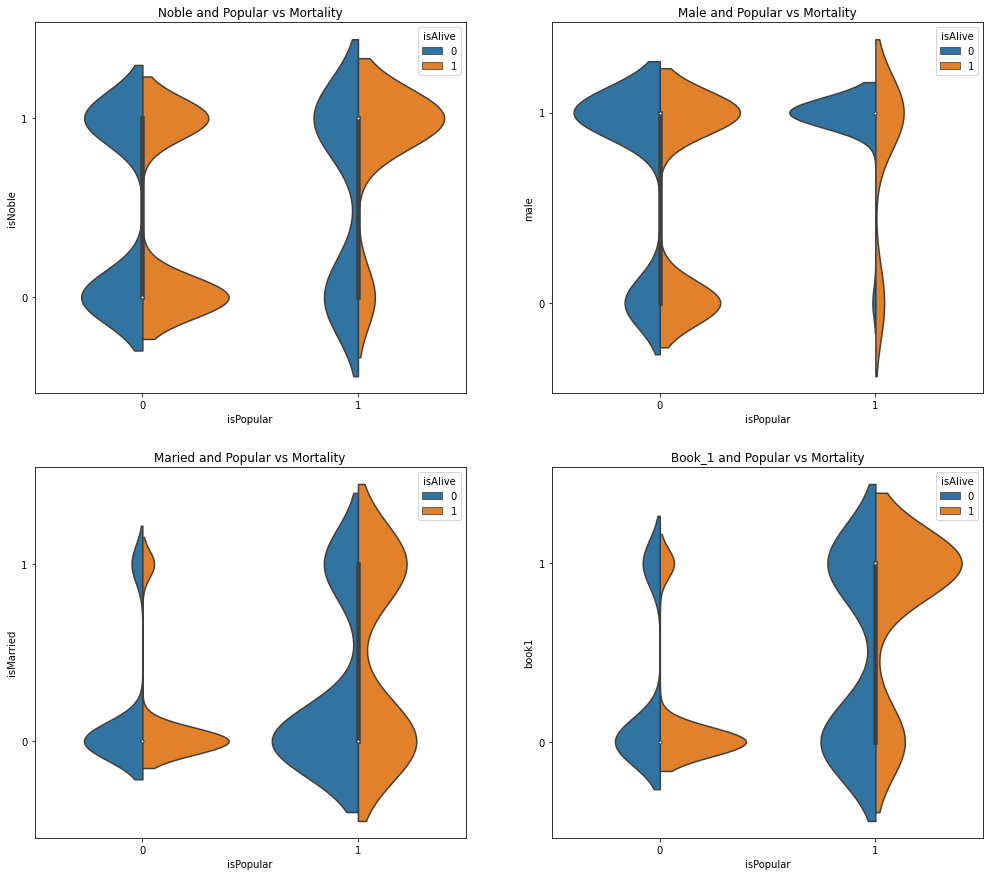

In [19]:
# analisando a "mortalidade" dos personagens

# declarando os subplots
fig, ax = plt.subplots(2, 2, figsize=(17, 15))

# nobre e popular vs mortalidade
sns.violinplot("isPopular", "isNoble", hue="isAlive", data=df_char_pred, split=True, ax=ax[0, 0])
ax[0, 0].set_title("Noble and Popular vs Mortality")
ax[0, 0].set_yticks(range(2))

# homem e popular vs mortalidade
sns.violinplot("isPopular", "male", hue="isAlive", data=df_char_pred, split=True, ax=ax[0, 1])
ax[0, 1].set_title("Male and Popular vs Mortality")
ax[0, 1].set_yticks(range(2))

# casado e popular vs mortalidade
sns.violinplot("isPopular", "isMarried", hue="isAlive", data=df_char_pred, split=True, ax=ax[1, 0])
ax[1, 0].set_title("Maried and Popular vs Mortality")
ax[1, 0].set_yticks(range(2))

# livro1 and Popular vs Mortalidade
sns.violinplot("isPopular", "book1", hue="isAlive", data=df_char_pred ,split=True, ax=ax[1, 1])
ax[1, 1].set_title('Book_1 and Popular vs Mortality')
ax[1, 1].set_yticks(range(2))

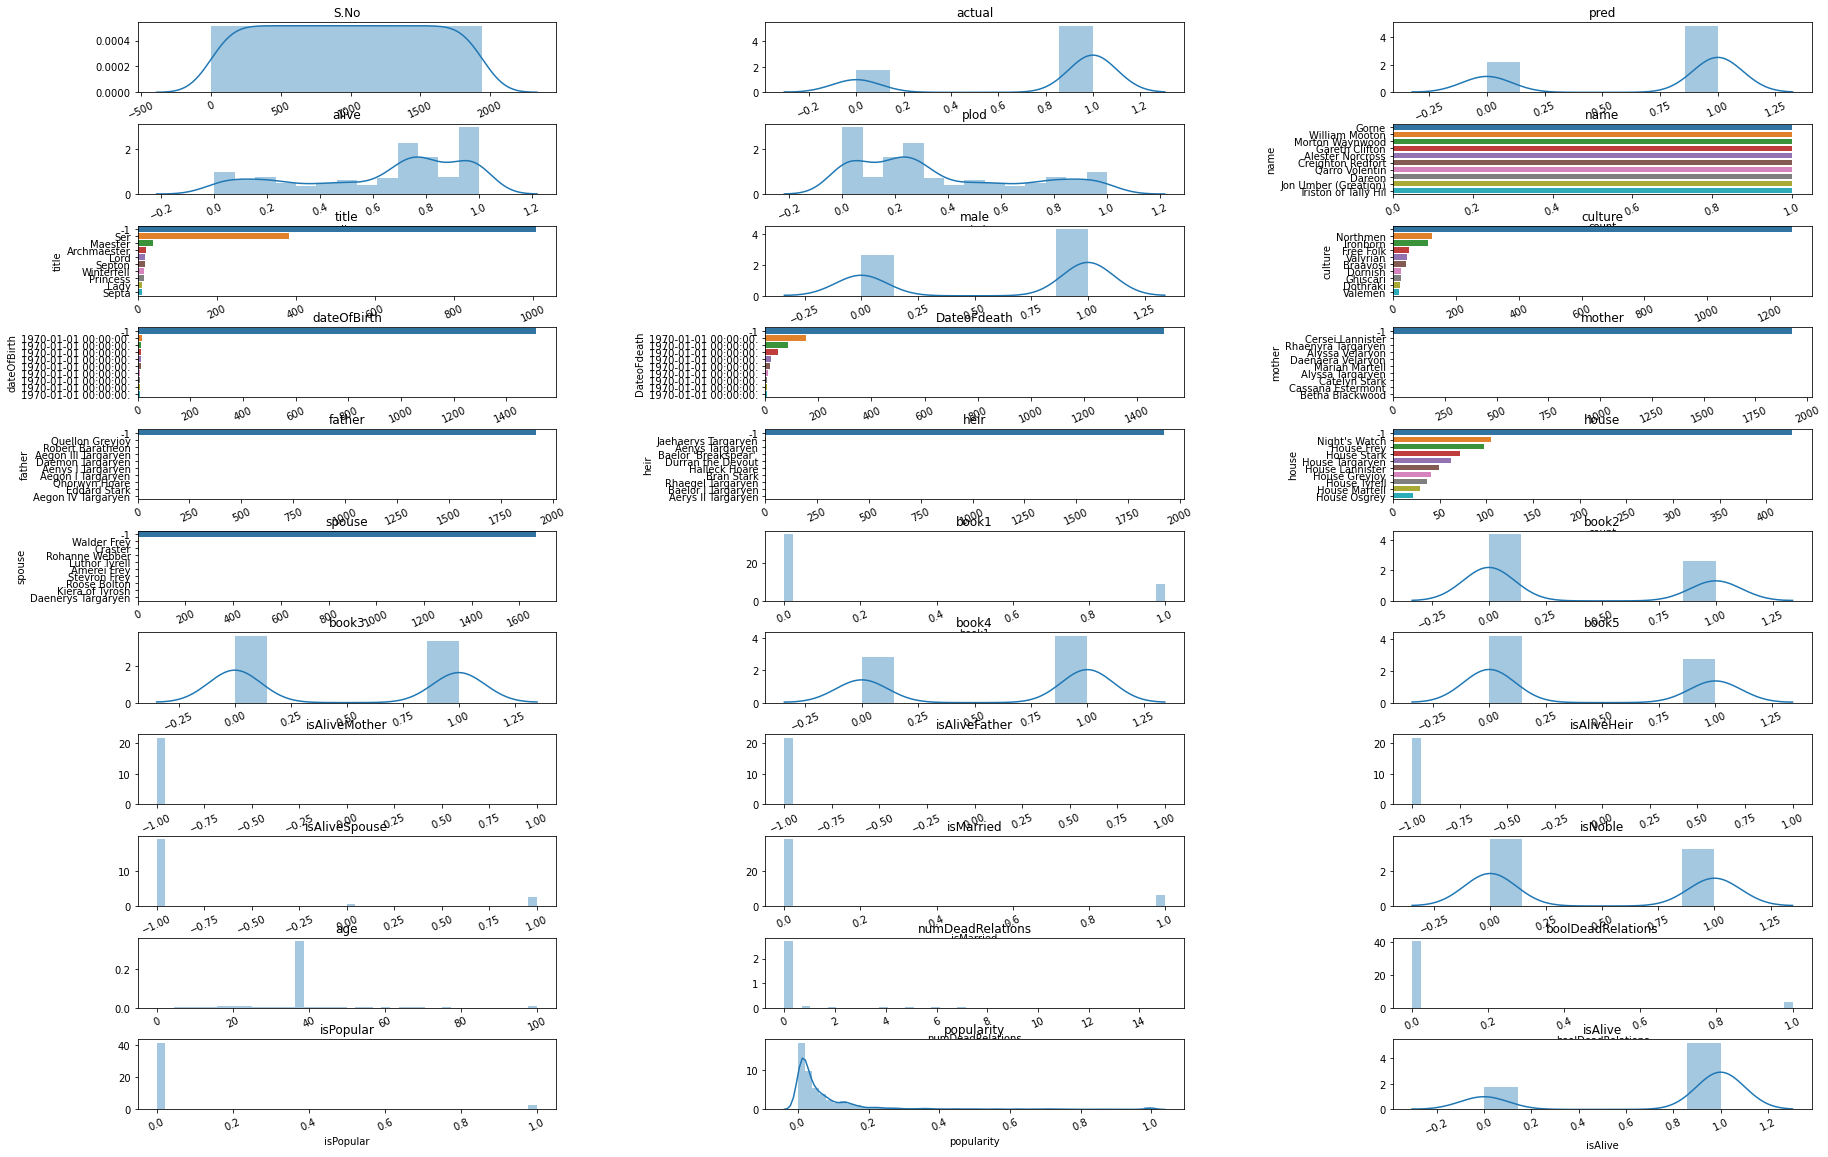

In [20]:
# chamando a função do gráfico de distribuição para cada feature do dataset
columns = df_char_pred.columns
plot_distribution(df_char_pred[columns], cols=3, width=30, height=20, hspace=0.45, wspace=0.5)

### Observações
- Mostramos a descrição do dataset.
- Verificamos a média da feature age e vimos que tem um erro a média era -1293.5635103926097.
- Verificamos quais os registros com a idade negativa:
    - (1684) Doreah: -277980.0
    - (1868) Rhaego: -299001.0
- Substituimos os valores negativos:
    - (1684) Doreah: 25.0
    - (1868) Rhaego:  0.0
- Verificamos a média da feature age após substituir o valor, tendo uma média de 36.70438799076212.
- Verificamos os a quantidade de valores nulos:
    - title            1008
    - culture          1269
    - dateOfBirth      1513
    - DateoFdeath      1502
    - mother           1925
    - father           1920
    - heir             1923
    - house             427
    - spouse           1670
    - isAliveMother    1925
    - isAliveFather    1920
    - isAliveHeir      1923
    - isAliveSpouse    1670
    - age              1513
- Substituimos os valores nulos da feature age pela média da coluna age, da feature culture por uma string nula (""), e o resto do dataset pelo valor de -1.
- Verificamos a quantidade de valores nulos, e não existe mais valores nulos.
- Analisamos e plotamos gráficos de violino das features:
    - nobre e popular vs mortalidade
    - homem e popular vs mortalidade
    - casado e popular vs mortalidade
    - livro1 and Popular vs Mortalidade
- Chamamos a função do gráfico de distribuição para cada feature.

## Verificando Anomalias

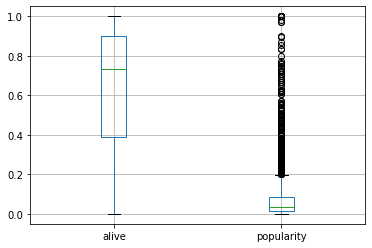

In [21]:
columns = ["alive", "popularity"]
df_char_pred.boxplot(column=columns)

In [22]:
# z-score para a feature popularity
z = np.abs(scipy.stats.zscore(df_char_pred["popularity"].values))
threshold = 2
result = np.where(z > threshold)
df_char_pred_outlier = df_char_pred.iloc[result[0]]

# mostrando o dataset com outliers
df_char_pred_outlier

,S.No,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,DateoFdeath,mother,father,heir,house,spouse,book1,book2,book3,book4,book5,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,1,0,0,0.054,0.946,Viserys II Targaryen,-1,1,,-1,-1,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,-1,-1,0,0,0,0,0,1.0,0.0,0.0,-1.0,0,0,36.704388,11,1,1,0.605351,0
1,2,1,0,0.387,0.613,Walder Frey,Lord of the Crossing,1,Rivermen,1970-01-01 00:00:00.000000208,-1,-1,-1,-1,House Frey,Perra Royce,1,1,1,1,1,-1.0,-1.0,-1.0,1.0,1,1,97.000000,1,1,1,0.896321,1
5,6,1,0,0.021,0.979,Tommen Baratheon,-1,1,,-1,-1,Cersei Lannister,Robert Baratheon,Myrcella Baratheon,-1,-1,0,0,0,0,0,1.0,1.0,1.0,-1.0,0,0,36.704388,5,1,1,1.000000,1
6,7,0,0,0.014,0.986,Valarr Targaryen,Hand of the King,1,Valyrian,1970-01-01 00:00:00.000000183,1970-01-01 00:00:00.000000209,-1,-1,-1,House Targaryen,Kiera of Tyrosh,0,0,0,0,0,-1.0,-1.0,-1.0,1.0,1,1,26.000000,0,0,1,0.431438,0
7,8,0,0,0.036,0.964,Viserys I Targaryen,-1,1,,-1,-1,Alyssa Targaryen,Baelon Targaryen,Rhaenyra Targaryen,-1,-1,0,0,0,0,0,1.0,1.0,1.0,-1.0,0,0,36.704388,5,1,1,0.678930,0
50,51,0,0,0.397,0.603,Joffrey Baratheon,-1,1,,-1,-1,Cersei Lannister,Robert Baratheon,Tommen Baratheon,-1,-1,0,0,0,0,0,1.0,1.0,1.0,-1.0,0,0,36.704388,5,1,1,1.000000,0
53,54,0,0,0.069,0.931,Maegor I Targaryen,-1,1,,-1,-1,Visenya Targaryen,Aegon I Targaryen,Jaehaerys Targaryen,-1,-1,0,0,0,0,0,0.0,0.0,1.0,-1.0,0,0,36.704388,0,0,1,0.705686,0
54,55,1,0,0.352,0.648,Margaery Tyrell,Seven Kingdoms,0,Reach,1970-01-01 00:00:00.000000283,-1,-1,-1,-1,House Tyrell,Renly Baratheon,1,1,1,1,1,-1.0,-1.0,-1.0,0.0,1,1,22.000000,3,1,1,1.000000,1
101,102,0,0,0.036,0.964,Robb Stark,-1,1,,-1,-1,Catelyn Stark,Eddard Stark,Bran Stark,-1,-1,0,0,0,0,0,0.0,0.0,1.0,-1.0,0,0,36.704388,7,1,1,1.000000,0
172,173,1,0,0.036,0.964,Stannis Baratheon,-1,1,,-1,-1,Cassana Estermont,Steffon Baratheon,Shireen Baratheon,-1,-1,0,0,0,0,0,0.0,0.0,1.0,-1.0,0,0,36.704388,4,1,1,1.000000,1


In [23]:
# mostrando a quantidade de valores missing
print(len(df_char_pred_outlier))

91


In [24]:
# mostrando o indice dos valores missing
df_char_pred_outlier.index

Int64Index([   0,    1,    5,    6,    7,   50,   53,   54,  101,  172,  273,
             280,  281,  282,  284,  289,  294,  296,  332,  432,  438,  506,
             620,  622,  636,  903,  967, 1466, 1474, 1475, 1481, 1496, 1506,
            1522, 1530, 1536, 1545, 1558, 1561, 1573, 1578, 1586, 1592, 1601,
            1604, 1606, 1607, 1620, 1622, 1642, 1646, 1648, 1651, 1658, 1665,
            1673, 1674, 1676, 1677, 1683, 1688, 1690, 1691, 1715, 1721, 1724,
            1741, 1744, 1749, 1751, 1763, 1781, 1784, 1785, 1792, 1798, 1824,
            1828, 1829, 1830, 1833, 1840, 1853, 1867, 1873, 1876, 1898, 1918,
            1919, 1925, 1927],
           dtype='int64')

### Observações
- Existem 91 valores missing na feature popularity.
- Os índices para os valores missing foram: (0, 1, 5, 6, 7, 50, 53, 54, 101, 172, 273, 280, 281, 282, 284, 289, 294, 296, 332, 432, 438, 506, 620, 622, 636, 903, 967, 1466, 1474, 1475, 1481, 1496, 1506, 1522, 1530, 1536, 1545, 1558, 1561, 1573, 1578, 1586, 1592, 1601, 1604, 1606, 1607, 1620, 1622, 1642, 1646, 1648, 1651, 1658, 1665, 1673, 1674, 1676, 1677, 1683, 1688, 1690, 1691, 1715, 1721, 1724, 1741, 1744, 1749, 1751, 1763, 1781, 1784, 1785, 1792, 1798, 1824, 1828, 1829, 1830, 1833, 1840, 1853, 1867, 1873, 1876, 1898, 1918, 1919, 1925, 1927).
- Valores acima de 0.41471571906354504 são considerados anomalias na feature popularity.

## Explorando os Dados

Text(0.5, 1.0, 'Distribuição dos Personagens pela Feature Actual')

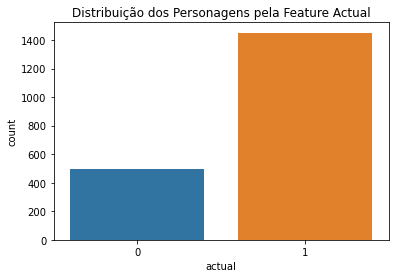

In [25]:
# analisando a distribuição dos personagens pela feature actual
sns.countplot(x="actual", data=df_char_pred)
plt.title("Distribuição dos Personagens pela Feature Actual")

In [26]:
# verificando a quantidade de valores unicos da feature actual
df_char_pred["actual"].value_counts()

1    1451
0     495
Name: actual, dtype: int64

Text(0.5, 1.0, 'Distribuição dos Personagens pela Feature Male')

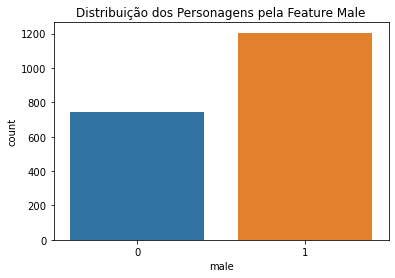

In [27]:
# analisando a distribuição dos personagens pela feature male
sns.countplot(x="male", data=df_char_pred)
plt.title("Distribuição dos Personagens pela Feature Male")

In [28]:
# verificando a quantidade de valores unicos da feature male
df_char_pred["male"].value_counts()

1    1205
0     741
Name: male, dtype: int64

Text(0.5, 1.0, 'Distribuição dos Personagens pela Feature Book1')

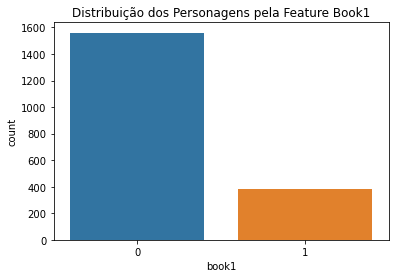

In [29]:
# analisando a distribuição dos personagens pela feature book1
sns.countplot(x="book1", data=df_char_pred)
plt.title("Distribuição dos Personagens pela Feature Book1")

In [30]:
# verificando a quantidade de valores unicos da feature book1
df_char_pred["book1"].value_counts()

0    1560
1     386
Name: book1, dtype: int64

Text(0.5, 1.0, 'Distribuição dos Personagens pela Feature Book2')

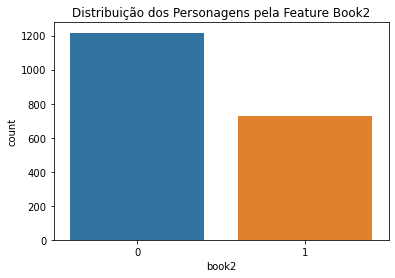

In [31]:
# analisando a distribuição dos personagens pela feature book2
sns.countplot(x="book2", data=df_char_pred)
plt.title("Distribuição dos Personagens pela Feature Book2")

In [32]:
# verificando a quantidade de valores unicos da feature book2
df_char_pred["book2"].value_counts()

0    1217
1     729
Name: book2, dtype: int64

Text(0.5, 1.0, 'Distribuição dos Personagens pela Feature Book3')

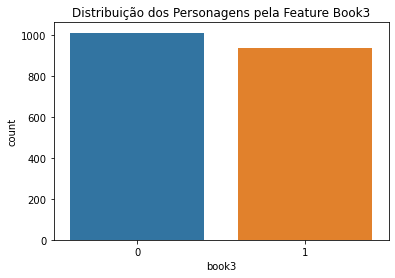

In [33]:
# analisando a distribuição dos personagens pela feature book3
sns.countplot(x="book3", data=df_char_pred)
plt.title("Distribuição dos Personagens pela Feature Book3")

In [34]:
# verificando a quantidade de valores unicos da feature book3
df_char_pred["book3"].value_counts()

0    1011
1     935
Name: book3, dtype: int64

Text(0.5, 1.0, 'Distribuição dos Personagens pela Feature Book4')

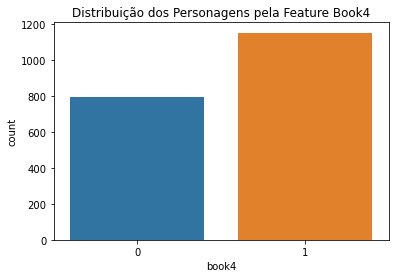

In [35]:
# analisando a distribuição dos personagens pela feature book4
sns.countplot(x="book4", data=df_char_pred)
plt.title("Distribuição dos Personagens pela Feature Book4")

In [36]:
# verificando a quantidade de valores unicos da feature book4
df_char_pred["book4"].value_counts()

1    1152
0     794
Name: book4, dtype: int64

Text(0.5, 1.0, 'Distribuição dos Personagens pela Feature Book5')

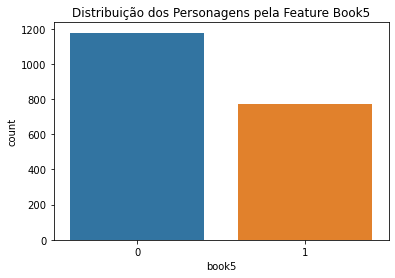

In [37]:
# analisando a distribuição dos personagens pela feature book5
sns.countplot(x="book5", data=df_char_pred)
plt.title("Distribuição dos Personagens pela Feature Book5")

In [38]:
# verificando a quantidade de valores unicos da feature book5
df_char_pred["book5"].value_counts()

0    1177
1     769
Name: book5, dtype: int64

Text(0.5, 1.0, 'Distribuição dos Personagens pela Feature isMarried')

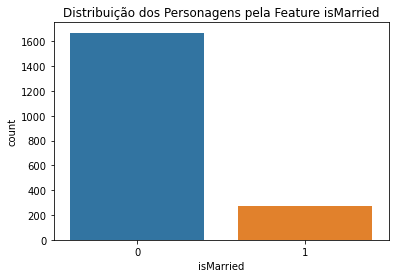

In [39]:
# analisando a distribuição dos personagens pela feature isMarried
sns.countplot(x="isMarried", data=df_char_pred)
plt.title("Distribuição dos Personagens pela Feature isMarried")

In [40]:
# verificando a quantidade de valores unicos da feature isMarried
df_char_pred["isMarried"].value_counts()

0    1670
1     276
Name: isMarried, dtype: int64

Text(0.5, 1.0, 'Distribuição dos Personagens pela Feature isNoble')

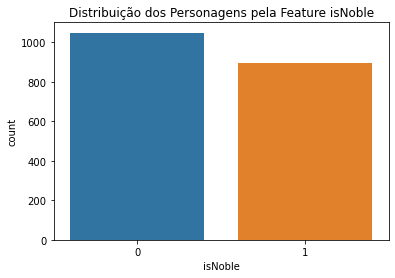

In [41]:
# analisando a distribuição dos personagens pela feature isNoble
sns.countplot(x="isNoble", data=df_char_pred)
plt.title("Distribuição dos Personagens pela Feature isNoble")

In [42]:
# verificando a quantidade de valores unicos da feature isNoble
df_char_pred["isNoble"].value_counts()

0    1049
1     897
Name: isNoble, dtype: int64

Text(0.5, 1.0, 'Distribuição dos Personagens pela Feature isPopular')

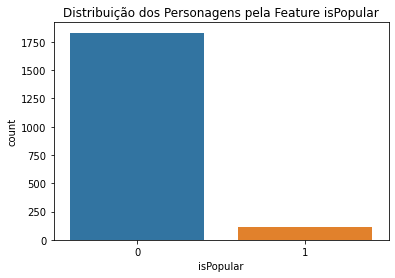

In [43]:
# analisando a distribuição dos personagens pela feature isPopular
sns.countplot(x="isPopular", data=df_char_pred)
plt.title("Distribuição dos Personagens pela Feature isPopular")

In [44]:
# verificando a quantidade de valores unicos da feature isPopular
df_char_pred["isPopular"].value_counts()

0    1831
1     115
Name: isPopular, dtype: int64

### Observações
- Foram Observados 10 features, as features com apenas dois valores distintos:
    
    **1) actual:** temos mais valores 1 do que 0
        - 0 ==  495 (25 %)
        - 1 == 1451 (75 %)
    **2) male:** temos mais valores 1 do que 0
        - 0 == 1205 (62 %)
        - 1 ==  741 (38 %)
    **3) book1:** temos mais valores 0 do que 1
        - 0 == 1560 (80 %)
        - 1 ==  386 (20 %)
    **4) book2:** temos mais valores 0 do que 1
        - 0 == 1217 (63 %)
        - 1 ==  729 (37 %)
    **5) book3:** temos mais valores 0 do que 1
        - 0 == 1011 (52 %)
        - 1 ==  935 (48 %)
    **6) book4:** temos mais valores 1 do que 0
        - 0 == 1152 (59 %)
        - 1 ==  794 (41 %)
    **7) book5:** temos mais valores 0 do que 1
        - 0 == 1177 (60 %)
        - 1 ==  769 (40 %)
    **8) isMarried:** temos mais valores 0 do que 1
        - 0 == 1670 (86 %)
        - 1 ==  276 (14 %)
    **9) isNoble:** temos mais valores 0 do que 1
        - 0 == 1049 (54 %)
        - 1 ==  897 (46 %)
    **10) isPopular:** temos mais valores 0 do que 1
        - 0 == 1831 (93 %)
        - 1 ==  115 (07 %)

## Preparando o Dataset

In [45]:
# retirando algumas colunas
drop = ["S.No", "pred", "alive", "plod", "name", "isAlive", "DateoFdeath"]
df_char_pred.drop(drop, inplace=True, axis=1)

# salvando uma cópia do dataset para aplicar o one hot encoder
df_char_pred_2 = df_char_pred.copy(deep=True)

In [46]:
# transformando os dados categóricos em one-hot-encoder
df_char_pred_2 = pd.get_dummies(df_char_pred_2)

In [47]:
# mostrando o dataset depois da transformação
df_char_pred_2.head()

,actual,male,book1,book2,book3,book4,book5,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,title_-1,title_Acorn Hall,title_Andals,title_Arbor,title_Archmaester,title_Ashford,title_Banefort,title_Barrowton,title_Bear Island,title_Big BucketThe Wull,title_Bitterbridge,title_Black Wind,title_Blackcrown,title_Blackmont,title_Blacktyde,title_Bloodrider,title_Blue Grace,title_Brightwater,title_Broad Arch,title_Brother,title_BrotherProctor,title_Captain,title_Captain of the guard,title_Captain-General,title_Castellan,title_Castellan of Harrenhal,title_CastellanCommander,title_Casterly Rock,title_Castle Lychester,title_Cerwyn,title_Chief Undergaoler,title_Claw Isle,title_Cobblecat,title_Coldmoat,title_Coldwater Burn,title_Commander of the City Watch,title_Commander of the Second Sons,title_Crag,title_Crakehall,title_Cupbearer,title_Darry,title_Deepwood Motte,title_Dragonstone,title_Dreadfort,title_Duskendale,title_Dyre Den,title_Eastwatch-by-the-Sea,title_Eyrie,title_Fair Isle,title_Feastfires,title_Felwood,title_First Builder,title_First Ranger,title_First Sword of Braavos,title_Foamdrinker,title_Ghost Hill,title_Godsgrace,title_Godswife,title_Golden Storm,title_Golden Tooth,title_Goldengrove,title_Goldgrass,title_Good Master,title_Goodman,title_Goodwife,title_Grand Maester,title_Grassy Vale,title_Green Grace,title_Greenshield,title_Greenstone,title_Grey Glen,title_Greywater Watch,title_Gulltown,title_Hand of the King,title_Harlaw,title_Harrenhal,title_Harridan Hill,title_Hayford,title_Haystack Hall,title_Heart's Home,title_High Septon,title_High Steward of Highgarden,title_Highgarden,title_Hightower,title_Horn Hill,title_Hornvale,title_Hornwood,title_Iron Islands,title_Ironoaks,title_Karhold,title_Karl's Hold,title_Kayce,title_Keeper of the Gates of the Moon,title_Khal,title_KhalKo (formerly),title_Khalakka,title_King,title_King in the North,title_King of Astapor,title_King of Winter,title_King of the Andals,title_King of the Iron Islands,title_King-Beyond-the-Wall,title_Knight,title_Knight of Griffin's Roost,title_Lady,title_Lady Marya,title_Lady of Bear Island,title_Lady of Darry,title_Lady of Torrhen's Square,title_Lady of the Leaves,title_Lady of the Vale,title_LadyQueen,title_LadyQueenDowager Queen,title_Last Hearth,title_Light of the West,title_Lonely Light,title_Longbow Hall,title_Longsister,title_Longtable,title_Lord,title_Lord Captain of the Iron Fleet,title_Lord Commander of the Night's Watch,title_Lord Paramount of the Mander,title_Lord Paramount of the Stormlands,title_Lord Paramount of the Trident,title_Lord Reaper of Pyke,title_Lord Seneschal,title_Lord Steward,title_Lord Steward of the Iron Islands,title_Lord of Atranta,title_Lord of Blackhaven,title_Lord of Coldmoat,title_Lord of Crows Nest,title_Lord of Darry,title_Lord of Dragonstone,title_Lord of Flint's Finger,title_Lord of Greyshield,title_Lord of Griffin's Roost,title_Lord of Hammerhorn,title_Lord of Harrenhal,title_Lord of Hellholt,title_Lord of Honeyholt,title_Lord of Iron Holt,title_Lord of Kingsgrave,title_Lord of Oakenshield,title_Lord of Oldcastle,title_Lord of Pebbleton,title_Lord of Southshield,title_Lord of Starfall,title_Lord of Sunflower Hall,title_Lord of White Harbor,title_Lord of the Crossing,title_Lord of the Deep Den,title_Lord of the Hornwood,title_Lord of the Iron Islands,title_Lord of the Marches,title_Lord of the Red Dunes,title_Lord of the Seven Kingdoms,title_Lord of the Snakewood,title_Lord of the Ten TowersLord Harlaw of HarlawHarlaw of Harlaw,title_Lord of the Tides,title_Lord of the Tor,title_LordWisdom,title_Lordsport,title_Maester,title_Magister,title_Magister of Pentos,title_Magnar of Thenn,title_Maidenpool,title_Master of Coin,title_Master of Deepwood Motte,title_Master of Harlaw Hall,title_Master of Whisperers,title_Master of coin,title_Master of whisperers,title_Master-at-Arms,title_Mistress of whisperers,title_Nightsong,title_Oakenshield,title_Oa

In [48]:
# mostrando a dimensão do antigo dataset
df_char_pred.shape

(1946, 26)

In [49]:
# mostrando a dimensão do novo dataset
df_char_pred_2.shape

(1946, 1146)

### Observações
- Retiramos algumas features: ("S.No", "pred", "alive", "plod", "name", "isAlive", "DateoFdeath").
- Salvamos uma cópia do dataset para aplicar o one hot encoder.
- Transformamos os dados categóricos em one hot encoder.
- Mostramos o dataset depois da transformação.
- Mostramos a dimensão do antigo dataset (1946, 26).
- Mostramos a dimensão do novo dataset (1946, 1146).
- Percebemos que quando aplicamos o one hot encoder as nossas features aumentam absurdamente.

## Aplicando os Modelos de Classificação

In [50]:
# separando o dataset entre entradas e saídas
X = df_char_pred_2.iloc[:, 1:].values
y = df_char_pred_2.iloc[:, 0].values

In [51]:
# aplicando o modelo de validação cruzada dividindo o dataset entre 5 diferentes grupos
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [52]:
# construindo os modelos de classificação
modelos = [LogisticRegression(solver="liblinear"), RandomForestClassifier(n_estimators=400, random_state=42),
          DecisionTreeClassifier(random_state=42), SVC(kernel="rbf", gamma="scale", random_state=42),
          KNeighborsClassifier(n_neighbors=3)]

In [53]:
# utilizando a validação cruzada
mean = []
std = []
for model in modelos:
    result = cross_val_score(model, X, y, cv=kfold, scoring="accuracy", n_jobs=-1)
    mean.append(result)
    std.append(result)

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Distribuição de cada um dos classificadores')

Text(0.5, 0, 'Acurácia')

([], <a list of 0 Text major ticklabel objects>)

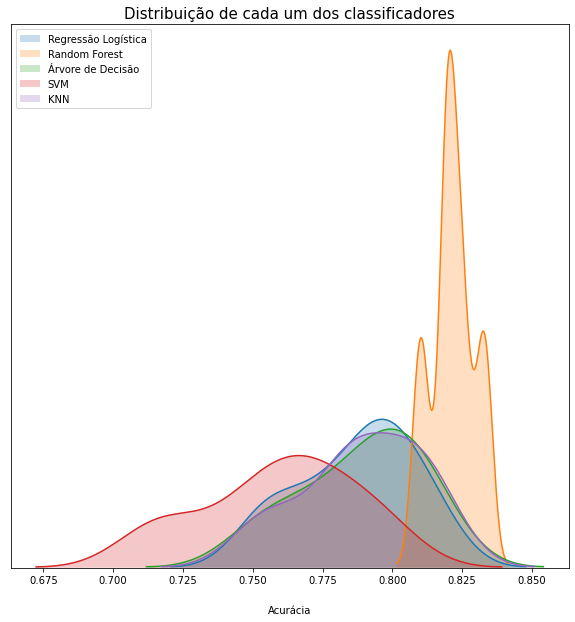

In [54]:
# plotando o gráfico de distribuição de cada um dos classificadores
classificadores=['Regressão Logística', 'Random Forest', 'Árvore de Decisão', 'SVM', 'KNN']

plt.figure(figsize=(10, 10))
for i in range(len(mean)):
    sns.distplot(mean[i], hist=False, kde_kws={"shade": True})
    
plt.title("Distribuição de cada um dos classificadores", fontsize=15)
plt.legend(classificadores)
plt.xlabel("Acurácia", labelpad=20)
plt.yticks([])

plt.show()

### Observações
- Separamos os dados de entrada X (todas as features) e os dados de saída y (actual).
- Aplicamos o modelo de validação cruzada dividindo o dataset entre 5 grupos diferentes.
- Construimos os 5 modelos:
    - Regressão Logistica
    - Random Florest
    - Decision Tree
    - SVM
    - KNN
- Aplicando os modelos com a validação cruzada.
- Plotando o gráfico de distribuição de cada um dos classificadores.
- Entre os classificadores testados, escolhemos dois modelos para trabalhar (SVM, Random Florest).

## Aplicando os Modelos de Classificação Escolhidos

In [55]:
# divindo os dados em treino e teste (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

## SVM

In [56]:
# criando o modelo do classificador
svm_clf = SVC(C=0.9, gamma=0.1, kernel="rbf", probability=True, random_state=42)

# treinando o modelo
svm_clf.fit(X_train, y_train)

# realizando a previsão probabilistica
svm_prob = svm_clf.predict_proba(X_test)

# valores reais
svm_pred = np.argmax(svm_prob, axis=1)

SVC(C=0.9, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [57]:
# mostrando a matriz de confusão
svm_matr_conf = confusion_matrix(y_test, svm_pred)
print(svm_matr_conf)

[[ 34  65]
 [ 18 273]]


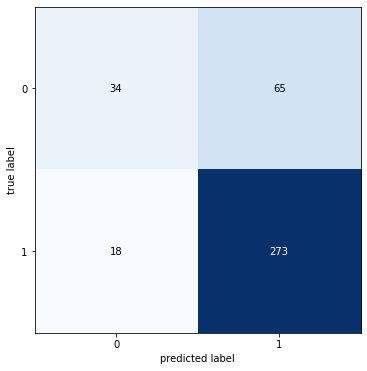

In [58]:
# plotando a matriz de confusão
fig, ax = plot_confusion_matrix(conf_mat=svm_matr_conf, figsize=(6, 6))
plt.show()

In [59]:
# mostrando o relatório do classificador
svm_class_report = classification_report(y_test, svm_pred)
print(svm_class_report)

              precision    recall  f1-score   support

           0       0.65      0.34      0.45        99
           1       0.81      0.94      0.87       291

    accuracy                           0.79       390
   macro avg       0.73      0.64      0.66       390
weighted avg       0.77      0.79      0.76       390



In [60]:
# criando as métricas
svm_acuracia = accuracy_score(y_test, svm_pred)
svm_precisao = precision_score(y_test, svm_pred, average="weighted")
svm_recall = recall_score(y_test, svm_pred, average='weighted')
svm_f1Score = f1_score(y_test, svm_pred, average="weighted")

In [61]:
# mostrando as métricas
print("Acurácia: {0}".format(round(svm_acuracia, 2)))
print("Precisão: {0}".format(round(svm_precisao, 2)))
print("Recall:   {0}".format(round(svm_recall, 2)))
print("F1 Score: {0}".format(round(svm_f1Score, 2)))

Acurácia: 0.79
Precisão: 0.77
Recall:   0.79
F1 Score: 0.76


### Random Florest

In [62]:
# criando o objeto do classificador
rf_clf = RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)

# treinando o modelo
rf_clf.fit(X_train, y_train)

# fazendo a previsão probabilistica
rf_prob = rf_clf.predict_proba(X_test)

# valores reais
rf_pred = np.argmax(rf_prob, axis=1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [63]:
# mostrando a matriz de confusão
rf_matr_conf = confusion_matrix(y_test, rf_pred)
print(rf_matr_conf)

[[ 46  53]
 [ 16 275]]


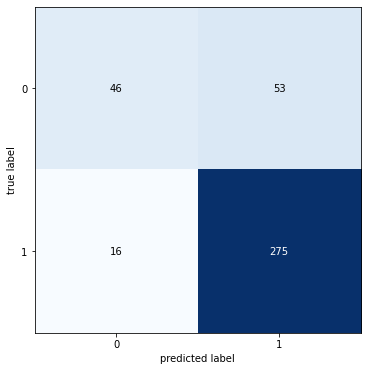

In [64]:
# plotando a matriz de confusão
fig, ax = plot_confusion_matrix(conf_mat=rf_matr_conf, figsize=(6, 6))
plt.show()

In [65]:
# mostrando o relatório do classificador
rf_class_report = classification_report(y_test, rf_pred)
print(rf_class_report)

              precision    recall  f1-score   support

           0       0.74      0.46      0.57        99
           1       0.84      0.95      0.89       291

    accuracy                           0.82       390
   macro avg       0.79      0.70      0.73       390
weighted avg       0.81      0.82      0.81       390



In [66]:
# criando as métricas
rf_acuracia = accuracy_score(y_test, rf_pred)
rf_precisao = precision_score(y_test, rf_pred, average="weighted")
rf_recall   = recall_score(y_test, rf_pred, average="weighted")
rf_f1Score  = f1_score(y_test, rf_pred, average="weighted") 

In [67]:
# mostrando as métricas
print("Acurácia: {0}".format(round(rf_acuracia, 2)))
print("Precisão: {0}".format(round(rf_precisao, 2)))
print("Recall:   {0}".format(round(rf_recall, 2)))
print("F1 Score: {0}".format(round(rf_f1Score, 2)))

Acurácia: 0.82
Precisão: 0.81
Recall:   0.82
F1 Score: 0.81


### Observações
- Dividimos os dados em treino (80 %) e teste (20 %).
- Aplicamos o modelo de classificação SVM:
    - Criamos o modelo do classificador
    - Treinamos o modelo
    - Realizamos a previsão probabilistica
    - Criamos os valores reais
    - Mostramos a matriz de confusão
    - Plotamos a matriz de confusão
    - Mostramos o relatório do classificador
    - Criamos e mostramos as métricas de qualidade:
        - Acurácia: 0.79
        - Precisão: 0.77
        - Recall:   0.79
        - F1 Score: 0.76
- Aplicamos o modelo de classificação RANDOM FLOREST:
    - Criamos o modelo do classificador
    - Treinamos o modelo
    - Realizamos a previsão probabilistica
    - Criamos os valores reais
    - Mostramos a matriz de confusão
    - Plotamos a matriz de confusão
    - Mostramos o relatório do classificador
    - Criamos e mostramos as métricas de qualidade:
        - Acurácia: 0.82
        - Precisão: 0.81
        - Recall:   0.82
        - F1 Score: 0.81

### Comparando os Modelos

In [68]:
# svm x random florest
print("Modelos:  SVM  x RANDOM FLOREST")
print("Acurácia: {0} x      {1}".format(round(svm_acuracia, 2), round(rf_acuracia, 2)))
print("Precisão: {0} x      {1}".format(round(svm_precisao, 2), round(rf_precisao, 2)))
print("Recall:   {0} x      {1}".format(round(svm_recall, 2), round(rf_recall, 2)))
print("F1 Score: {0} x      {1}".format(round(svm_f1Score, 2), round(rf_f1Score, 2)))

Modelos:  SVM  x RANDOM FLOREST
Acurácia: 0.79 x      0.82
Precisão: 0.77 x      0.81
Recall:   0.79 x      0.82
F1 Score: 0.76 x      0.81


Text(0.5, 1.0, 'SVM')

[Text(114.0, 0.5, 'Valor Real'), Text(0.5, 24.0, 'Previsão')]

Text(0.5, 1.0, 'Random Florest')

[Text(570.5454545454544, 0.5, 'Valor Real'), Text(0.5, 24.0, 'Previsão')]

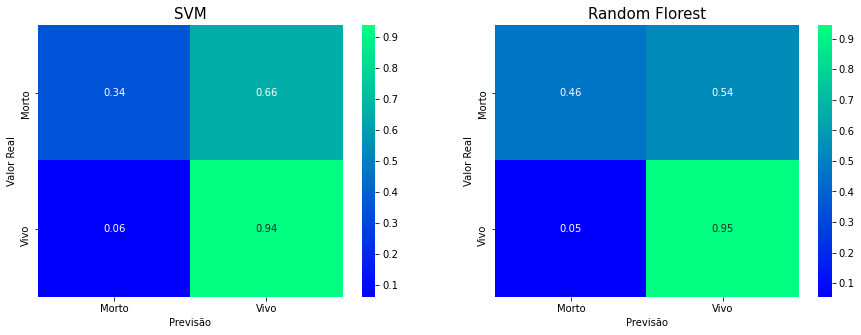

In [69]:
# criando a porcentagem de acertos

# svm
cm = svm_matr_conf
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# random florest
cm2 = rf_matr_conf
cm2 = cm2.astype("float") / cm2.sum(axis=1)[:, np.newaxis]

# definindo as classes
classes = ["Morto", "Vivo"]

# plotando os gráficos de heatmap

# definindo os subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# svm
ax[0].set_title("SVM", fontsize=15.)
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), cmap="winter", annot=True, 
            fmt=".2f", ax=ax[0]).set(xlabel="Previsão", ylabel="Valor Real")

# random florest
ax[1].set_title("Random Florest", fontsize=15.)
sns.heatmap(pd.DataFrame(cm2, index=classes, columns=classes), cmap="winter", annot=True,
           fmt=".2f", ax=ax[1]).set(xlabel="Previsão", ylabel="Valor Real")

### Observações
- Comparamos as metricas dos dois modelos escolhidos.
- O modelo do random florest foi um pouco superior do que o modelo svm.
- O modelo SVM teve:
    - 94 % de acertos em vivos.
    - 34 % de acertos em mortos.
- O modelo Random Florest teve:
    - 95 % de acertos em vivos.
    - 46 % de acertos em mortos.